In [2]:
import os
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


2025-02-03 09:46:53.987391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 09:46:54.039531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 09:46:54.054893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 09:46:54.125706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-03 09:46:55.522658: W tensorflow/compiler/tf2

In [3]:
model_name = 'sayeed99/segformer_b3_clothes'

In [4]:
# Load the image processor and the pre-trained model for semantic segmentation
processor = SegformerImageProcessor.from_pretrained(model_name)
model = AutoModelForSemanticSegmentation.from_pretrained(model_name)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

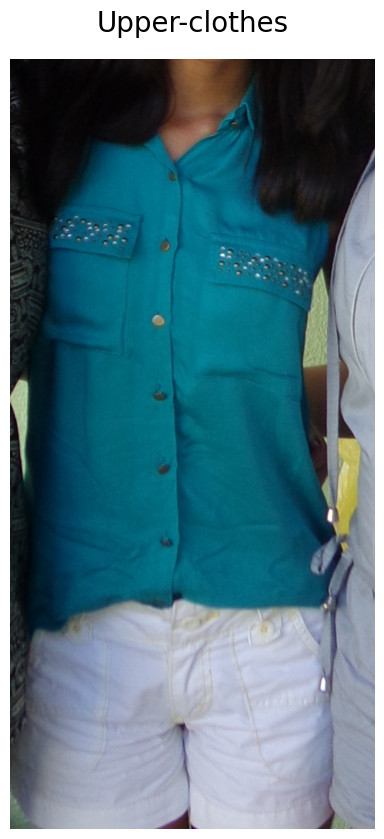

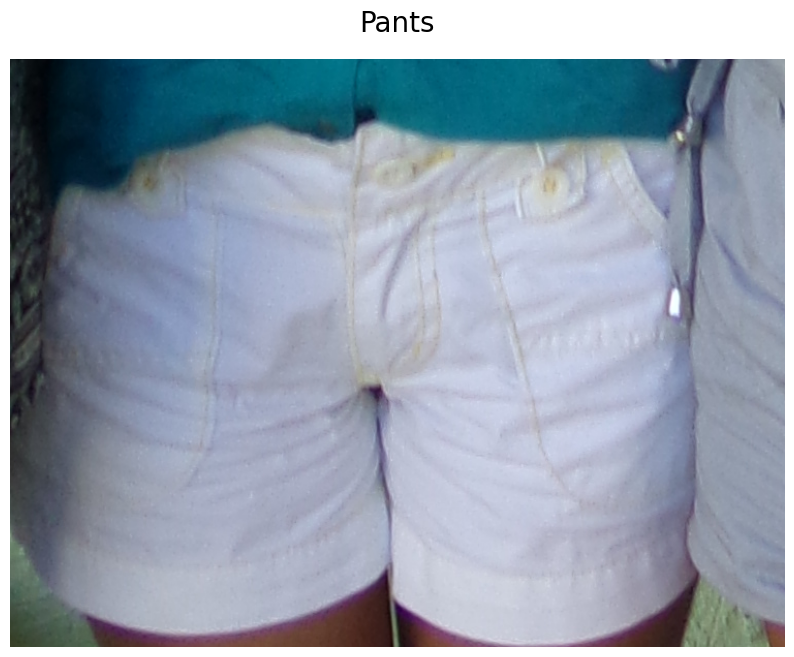

In [17]:
#predict_img = '/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/detection/100_0144.JPG'
predict_img = '/home/jcaldeira/dressing_virtuel_data_collector/media/tmp/detection/image_1729022134_9d63d9.png'

image = Image.open(predict_img)
if image.mode != "RGB":
    image = image.convert("RGB")

inputs = processor(images=image, return_tensors="pt")

# Move inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Perform inference to obtain logits from the model
outputs = model(**inputs)
logits = outputs.logits

# Upsample the logits to match the original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],  # Reverse the size to (height, width)
    mode="bilinear",
    align_corners=False,
)

# Generate segmentation map and filter valid labels
pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
probabilities = nn.functional.softmax(upsampled_logits, dim=1)

certainty_mask = probabilities.max(dim=1).values > 0.7
certainty_mask_np = certainty_mask.squeeze().cpu().numpy()
valid_labels = [lbl for lbl in np.unique(pred_seg[certainty_mask_np]) if lbl in [4, 5, 6, 7]]

for label in valid_labels:
    # Convert the segmentation map to a binary mask for the target class
    target_class = label  # Define the class to be extracted
    binary_mask = (pred_seg == target_class).astype(np.uint8)

    # Find the bounding box of the target segment using non-zero indices of the binary mask
    non_zero_indices = np.nonzero(binary_mask)
    
    # Calculate the bounding box limits (min and max coordinates)
    min_y, max_y = np.min(non_zero_indices[0]), np.max(non_zero_indices[0])
    min_x, max_x = np.min(non_zero_indices[1]), np.max(non_zero_indices[1])

    # Crop the original image using the calculated bounding box limits
    cropped_image = image.crop((min_x, min_y, max_x, max_y))

    # Display the cropped image
    if label == 4:
         title = "Upper-clothes"
    elif label == 5:
         title = "Skirt"
    elif label == 6:
         title = "Pants"
    elif label == 6:
        title =  "Dress"
    else:
        title =  "N/A"
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image)
    plt.title(title, fontsize=20, loc='center', pad=20)
    plt.axis("off")
    plt.show()

In [14]:
outputs

SemanticSegmenterOutput(loss=None, logits=tensor([[[[11.9579, 12.9984, 12.9969,  ..., 14.3225, 14.3484, 14.6057],
          [ 8.0109,  8.2500, 10.5215,  ..., 14.3122, 14.6831, 15.7421],
          [ 6.5514,  7.3373,  6.6102,  ..., 13.5475, 13.8106, 14.9967],
          ...,
          [14.8170, 15.0759, 14.5754,  ..., 11.9540, 11.9784, 12.4174],
          [15.3923, 15.8714, 15.2507,  ..., 11.7827, 12.2959, 12.3605],
          [16.7989, 17.4338, 16.7249,  ..., 10.5577, 12.3055, 12.5946]],

         [[-3.5971, -3.8469, -3.9439,  ..., -4.5412, -4.7039, -5.0663],
          [-2.5967, -2.5773, -2.8947,  ..., -4.1511, -4.3797, -4.8957],
          [-3.5809, -3.7167, -2.8199,  ..., -3.7216, -3.8599, -4.1030],
          ...,
          [-5.7540, -5.5613, -5.3195,  ..., -2.1617, -2.3803, -2.3794],
          [-5.6775, -5.6335, -5.3806,  ..., -2.1791, -2.3606, -2.3859],
          [-5.9781, -5.7491, -5.5320,  ..., -1.8557, -2.1178, -2.1000]],

         [[-3.0717, -3.8823, -3.5940,  ..., -4.4537, -4.5748

In [6]:
from transformers import AutoModelForSemanticSegmentation, SegformerImageProcessor
from datasets import load_dataset
import evaluate
import torch

### fashion_segmentation

In [7]:
dataset = load_dataset("sayeed99/fashion_segmentation")


Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 45193
    })
})

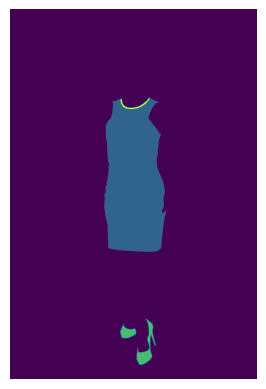

In [9]:
plt.imshow(dataset['train'][2]['label'])
plt.axis('off')
plt.show()

In [10]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from datasets import load_dataset
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load the processor and model
processor = SegformerImageProcessor.from_pretrained("sayeed99/segformer_b3_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("sayeed99/segformer_b3_clothes").to(device)
model.eval()

# Load the dataset (replace 'test' with your desired split)
dataset = load_dataset("sayeed99/fashion_segmentation", split="train")

# Function to calculate metrics
def evaluate_segmentation(predictions, ground_truth, num_classes):
    confusion = confusion_matrix(ground_truth.flatten(), predictions.flatten(), labels=range(num_classes))
    pixel_accuracy = np.diag(confusion).sum() / confusion.sum()
    class_iou = np.diag(confusion) / (confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion))
    mean_iou = np.nanmean(class_iou)
    return pixel_accuracy, mean_iou, class_iou

# Placeholder for evaluation
num_classes = 17  # Adjust based on your labels
all_preds = []
all_labels = []

for idx, sample in enumerate(dataset.select(range(10))):
    # Preprocess the image
    image = Image.fromarray(np.array(sample['image']))
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Get ground truth mask
    ground_truth = np.array(sample['label'])
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Shape: [batch_size, num_classes, height, width]
        # Resize logits to match mask size
        logits_resized = F.interpolate(
            logits, 
            size=ground_truth.shape,  # (height, width) format
            mode="bilinear",
            align_corners=False
        )
        predictions = torch.argmax(logits_resized.squeeze(0), dim=0).cpu().numpy()  # Predicted mask

    print(f"Prediction shape after resizing: {predictions.shape}, Ground truth shape: {ground_truth.shape}")
    
    # Store predictions and labels
    all_preds.append(predictions)
    all_labels.append(ground_truth)

# Combine all predictions and labels
print(f"Prediction shape: {predictions.shape}, Ground truth shape: {ground_truth.shape}")

all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Evaluate
pixel_accuracy, mean_iou, class_iou = evaluate_segmentation(all_preds, all_labels, num_classes)
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Per-Class IoU: {class_iou}")

# Visualize a sample result
def visualize_sample(image, ground_truth, prediction):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap="jet", alpha=0.7)
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction, cmap="jet", alpha=0.7)
    plt.title("Prediction")
    plt.axis("off")
    plt.show()



Using device: cuda


Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/49 [00:00<?, ?it/s]

Prediction shape after resizing: (5214, 3676), Ground truth shape: (5214, 3676)
Prediction shape after resizing: (2448, 2448), Ground truth shape: (2448, 2448)
Prediction shape after resizing: (3000, 1997), Ground truth shape: (3000, 1997)
Prediction shape after resizing: (567, 400), Ground truth shape: (567, 400)
Prediction shape after resizing: (750, 500), Ground truth shape: (750, 500)
Prediction shape after resizing: (975, 650), Ground truth shape: (975, 650)
Prediction shape after resizing: (1000, 667), Ground truth shape: (1000, 667)
Prediction shape after resizing: (1600, 1067), Ground truth shape: (1600, 1067)
Prediction shape after resizing: (4000, 6000), Ground truth shape: (4000, 6000)
Prediction shape after resizing: (1280, 852), Ground truth shape: (1280, 852)
Prediction shape: (1280, 852), Ground truth shape: (1280, 852)
Pixel Accuracy: 0.7815
Mean IoU: 0.0590
Per-Class IoU: [9.37642458e-01 0.00000000e+00 4.11932714e-04 0.00000000e+00
 6.52583099e-02 0.00000000e+00 0.0000

In [18]:
# Example visualization
lookfor = 8
start_position = 0
for i, smp in enumerate(dataset.select(range(10))):
    if i != lookfor:
        start_position = start_position + np.array(dataset[i]['label']).size
        continue
    break



NameError: name 'dataset' is not defined

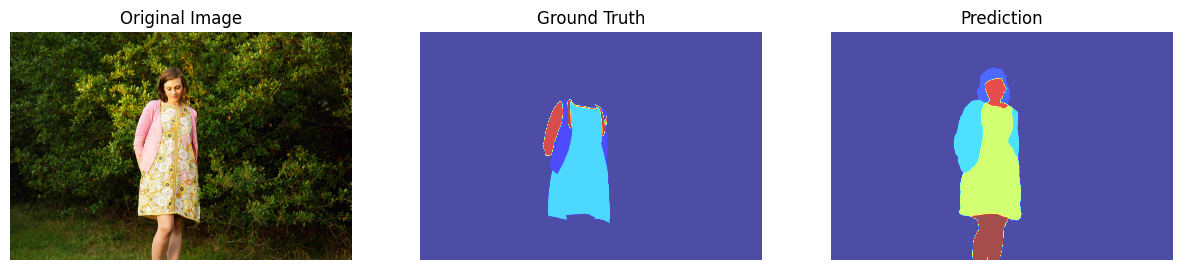

In [12]:
sample_image = np.array(dataset[lookfor]['image'])
sample_ground_truth = np.array(dataset[lookfor]['label'])
end_position = start_position + np.array(dataset[lookfor]['label']).size
sample_prediction = all_preds[start_position:end_position].reshape(sample_ground_truth.shape)
visualize_sample(sample_image, sample_ground_truth, sample_prediction)

### human_parsing_dataset

In [13]:
from datasets import load_dataset

dataset = load_dataset("mattmdjaga/human_parsing_dataset", split="train")

In [14]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 17706
})

In [15]:
ds_test = dataset.train_test_split(test_size=0.05)


In [16]:
ds_test['test']

Dataset({
    features: ['image', 'mask'],
    num_rows: 886
})

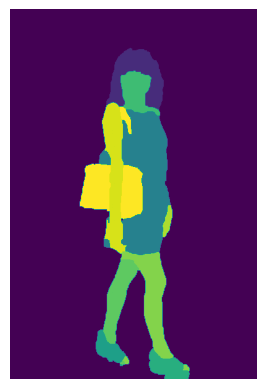

In [17]:
import matplotlib.pyplot as plt

plt.imshow(ds_test['test'][0]['mask'])
plt.axis('off')
plt.show()

In [18]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from datasets import load_dataset
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load the processor and model
processor = SegformerImageProcessor.from_pretrained("sayeed99/segformer_b3_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("sayeed99/segformer_b3_clothes").to(device)
model.eval()

# Load the dataset (replace 'test' with your desired split)
dataset = load_dataset("mattmdjaga/human_parsing_dataset", split="train")

# Function to calculate metrics
def evaluate_segmentation(predictions, ground_truth, num_classes):
    confusion = confusion_matrix(ground_truth.flatten(), predictions.flatten(), labels=range(num_classes))
    pixel_accuracy = np.diag(confusion).sum() / confusion.sum()
    class_iou = np.diag(confusion) / (confusion.sum(axis=1) + confusion.sum(axis=0) - np.diag(confusion))
    mean_iou = np.nanmean(class_iou)
    return pixel_accuracy, mean_iou, class_iou

# Placeholder for evaluation
num_classes = 17  # Adjust based on your labels
all_preds = []
all_labels = []

ds_train_test = dataset.train_test_split(test_size=0.05)
ds_test = ds_train_test['test']

for idx, sample in enumerate(ds_test):
    # Preprocess the image
    image = Image.fromarray(np.array(sample['image']))
    inputs = processor(images=image, return_tensors="pt").to(device)
    
    # Get ground truth mask
    ground_truth = np.array(sample['mask'])
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Shape: [batch_size, num_classes, height, width]
        # Resize logits to match mask size
        logits_resized = F.interpolate(
            logits, 
            size=ground_truth.shape,  # (height, width) format
            mode="bilinear",
            align_corners=False
        )
        predictions = torch.argmax(logits_resized.squeeze(0), dim=0).cpu().numpy()  # Predicted mask

    #print(f"Prediction shape after resizing: {predictions.shape}, Ground truth shape: {ground_truth.shape}")
    
    # Store predictions and labels
    all_preds.append(predictions)
    all_labels.append(ground_truth)

# Combine all predictions and labels
#print(f"Prediction shape: {predictions.shape}, Ground truth shape: {ground_truth.shape}")

all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Evaluate
pixel_accuracy, mean_iou, class_iou = evaluate_segmentation(all_preds, all_labels, num_classes)
print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Per-Class IoU: {class_iou}")

# Visualize a sample result
def visualize_sample(image, ground_truth, prediction):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth, cmap="jet", alpha=0.7)
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction, cmap="jet", alpha=0.7)
    plt.title("Prediction")
    plt.axis("off")
    plt.show()



Using device: cuda
Pixel Accuracy: 0.9614
Mean IoU: 0.6483
Per-Class IoU: [0.98438507 0.80481766 0.81244428 0.60995946 0.89989772 0.90747191
 0.89100873 0.91322798 0.45159729 0.36378884 0.22293681 0.84556988
 0.39240834 0.29253818 0.42925846 0.4000645  0.79965714]


In [19]:
# Example visualization
idx=202
sample_image = np.array(ds_test[idx]['image'])
sample_ground_truth = np.array(ds_test[idx]['mask'])
start_position = (idx) * sample_ground_truth.size
end_position = (idx+1) * sample_ground_truth.size
sample_prediction = all_preds[start_position:end_position].reshape(sample_ground_truth.shape)
visualize_sample(sample_image, sample_ground_truth, sample_prediction)


NameError: name 'ds_test' is not defined